In this notebook we will try to convert the keras model from 
<a href="https://www.kaggle.com/code/mariapushkareva/nlp-disaster-tweets-with-glove-and-lstm/notebook">NLP (Disaster Tweets) with Glove and LSTM</a> into a pytorch model.

It also draws references from the following notebooks

* <a href="https://pytorch.org/tutorials/beginner/text_sentiment_ngrams_tutorial.html">TEXT CLASSIFICATION WITH THE TORCHTEXT LIBRARY</a>
* <a href="https://www.kaggle.com/code/gunesevitan/nlp-with-disaster-tweets-eda-cleaning-and-bert/notebook">NLP with Disaster Tweets - EDA, Cleaning and BERT</a>
* <a href="https://www.kaggle.com/christofhenkel/how-to-preprocessing-when-using-embeddings">How to: Preprocessing when using embeddings</a>


# LIBRARIES

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from sklearn.metrics import (precision_score, recall_score, accuracy_score,
                             f1_score, roc_auc_score, classification_report)
from sklearn.model_selection import train_test_split

import torch
from torch import nn
from collections import Counter, OrderedDict
from torchtext.data.utils import get_tokenizer
from torchtext.vocab import vocab
from torch.utils.data import Dataset, DataLoader, random_split
from torch.nn import functional

from nltk.tokenize import word_tokenize
import re

from path import Path
from tqdm.notebook import tqdm

# LOADING DATASET

A cleaned datasset from <a href="https://www.kaggle.com/code/gunesevitan/nlp-with-disaster-tweets-eda-cleaning-and-bert/notebook">NLP with Disaster Tweets - EDA, Cleaning and BERT</a>

In [2]:
path = Path("/kaggle/input/nlp-with-disaster-tweets-eda-cleaning-and-bert")
train = pd.read_pickle(path / "train.pkl")
test = pd.read_pickle(path / "test.pkl")
sample_sub = pd.read_csv("/kaggle/input/nlp-getting-started/sample_submission.csv")


train.head()

,id,keyword,location,text,target,text_cleaned,target_relabeled
0,1,no_keyword,no_location,Our Deeds are the Reason of this #earthquake M...,1,Our Deeds are the Reason of this # earthquake...,1
1,4,no_keyword,no_location,Forest fire near La Ronge Sask. Canada,1,Forest fire near La Ronge Sask . Canada,1
2,5,no_keyword,no_location,All residents asked to 'shelter in place' are ...,1,All residents asked to ' shelter in place ' ...,1
3,6,no_keyword,no_location,"13,000 people receive #wildfires evacuation or...",1,"13,000 people receive # wildfires evacuation ...",1
4,7,no_keyword,no_location,Just got sent this photo from Ruby #Alaska as ...,1,Just got sent this photo from Ruby # Alaska a...,1


In [3]:
# lower case the text and replace "  " with " "
train['text_cleaned'] = train['text_cleaned'] .str.lower().map(lambda x: re.sub(' +', ' ', x))
test['text_cleaned']  = test['text_cleaned'].str.lower().map(lambda x: re.sub(' +', ' ', x))

In [4]:
# adding keyword with tweet
train['text_cleaed'] = train['text_cleaned'] + " " + train['keyword']
test['text_cleaed'] = test['text_cleaned'] + " " + test['keyword']

# CREATING A VOCABULARY

In [5]:
tokenizer = get_tokenizer(None)   # splits on " "
corpus = train['text_cleaned'].tolist()


counter = Counter()
for tweet in corpus:
    tokens = [token.strip() for token in tokenizer(tweet) if token not in '!"#$%&()*+,-./:;<=>?@[\\]^_`{|}~\t\n']
    counter.update(tokens) 
    
ordered_dict = OrderedDict(counter)


vocabulary = vocab(ordered_dict, specials=['pad', '<unk>']) # 0 for pad and 1 for <unk>
vocabulary.set_default_index(vocabulary['<unk>'])          # setting <unk> as oov token
vocab_size = len(vocabulary)
print(f"Our vocabulary has {vocab_size} words")

Our vocabulary has 16941 words


In [6]:
sorted(vocabulary.get_stoi().items(), key=lambda x: x[1])[:5]

[('pad', 0), ('<unk>', 1), ('our', 2), ('deeds', 3), ('are', 4)]

In [7]:
# now for a given word we will get the index position in the vocabulary
vocabulary(['hello', 'world'])

[3691, 1285]

# LOADING PRETRAINED GLOVE EMBEDDINGS

In [8]:
embeddings_dictionary = dict()
embedding_dim = 300
glove_file = open('/kaggle/input/glove-embeddings/glove.6B.300d.txt')

for line in glove_file:
    records = line.split()
    word = records[0]
    vector_dimensions = np.asarray(records[1:], dtype='float32')
    embeddings_dictionary [word] = vector_dimensions
    
glove_file.close()

In [9]:
embedding_matrix = np.zeros((vocab_size, embedding_dim))

for word, index in vocabulary.get_stoi().items():
    embedding_vector = embeddings_dictionary.get(word)
    if embedding_vector is not None:
        embedding_matrix[index] = embedding_vector
        
embedding_matrix.shape

(16941, 300)

A trick from <a href="https://www.kaggle.com/christofhenkel/how-to-preprocessing-when-using-embeddings">How to: Preprocessing when using embeddings</a>

In [10]:
def check_embeddings_coverage(): 
    covered = {}
    oov = {}    
    n_covered = 0
    n_oov = 0
    counts = 0;
    for word in ordered_dict.keys():
        if(embeddings_dictionary.get(word) is not None):
            covered[word] = embeddings_dictionary[word]
            n_covered += ordered_dict[word]
        else:
            oov[word] = ordered_dict[word]
            n_oov += ordered_dict[word]

    vocab_coverage = len(covered) / len(ordered_dict)
    text_coverage = (n_covered / (n_covered + n_oov))
    
    return oov, vocab_coverage, text_coverage


glove_oov, glove_vocab_coverage, glove_text_coverage = check_embeddings_coverage()
print("GloVe embeddings cover {:.2%} of the vocabulary and {:.2%} of the text".format(glove_vocab_coverage, glove_text_coverage))

GloVe embeddings cover 74.44% of the vocabulary and 95.60% of the text


# PYTORCH DATASET AND DATALOADER

In [11]:
longest_sentence = max(train['text_cleaned'].tolist() + test['text_cleaned'].tolist(), key=lambda x: len(tokenizer(x)))
max_word_count = len(tokenizer(longest_sentence))

class CFG:
    DEVICE = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    BATCH_SIZE = 32
    TRAIN_SIZE = 0.85
    NUM_CLASSES = 1
    EMBEDDING_DIM = embedding_dim
    VOCAB_SIZE = vocab_size
    EMBEDDING_MATRIX = embedding_matrix
    MAX_WORD_COUNT = max_word_count

****Creating dataset****

In [12]:
class DisasterTweetTrainDataset(Dataset):
    
    def __init__(self, texts, labels, tokenizer=tokenizer, vocabulary=vocabulary):
        self.texts = texts
        self.labels = labels
        self.tokenizer = tokenizer
        self.vocabulary = vocabulary
    
        
#     create tokens and return the index for those tokens
    def preprocess_text(self, text): 
        tokens = [token.strip() for token in self.tokenizer(text) if token not in '!"#$%&()*+,-./:;<=>?@[\\]^_`{|}~\t\n']
        return self.vocabulary(tokens)
    
    def __len__(self):
        return len(self.texts)
    
    
    def get_text(self, idx):
        text = self.texts[idx]
        label = self.labels[idx]
        
        return text, label
    
    def __getitem__(self, idx):
        text = self.texts[idx]
        label = self.labels[idx]
        
        preprocessed_text = torch.tensor(self.preprocess_text(text), dtype=torch.int64)
        padded_text = functional.pad(preprocessed_text, (0, CFG.MAX_WORD_COUNT - len(preprocessed_text)), value=0)
        
        return padded_text, label
    
    
class DisasterTweetTestDataset(Dataset):
    
    def __init__(self, texts, tokenizer=tokenizer, vocabulary=vocabulary):
        self.texts = texts
        self.tokenizer = tokenizer
        self.vocabulary = vocabulary
    
        
#     create tokens and return the index for those tokens
    def preprocess_text(self, text): 
        tokens = [token.strip() for token in self.tokenizer(text) if token not in '!"#$%&()*+,-./:;<=>?@[\\]^_`{|}~\t\n']
        return self.vocabulary(tokens)
    
    def __len__(self):
        return len(self.texts)

    def get_text(self, idx):
        text = self.texts[idx]
        
        return text
    
    def __getitem__(self, idx):
        text = self.texts[idx]
        
        preprocessed_text = torch.tensor(self.preprocess_text(text), dtype=torch.int64)
        padded_text = functional.pad(preprocessed_text, (0, CFG.MAX_WORD_COUNT - len(preprocessed_text)), value=0)
        
        return padded_text
        
        
train_df = train.sample(frac=1, random_state=42)      
train_dataset = DisasterTweetTrainDataset(train_df['text_cleaned'].values, train_df['target'].values)
test_dataset = DisasterTweetTestDataset(test['text_cleaned'].values)

In [13]:
print("For text ", train_dataset.get_text(0)[0])
print("We have the corresponding preprocessed text", train_dataset[0][0])
print("Here each value is the index position for the word in our vocabulary")

For text  so you have a new weapon that can cause un - imaginable destruction . 
We have the corresponding preprocessed text tensor([ 107,  168,  128,   55,  206, 2065,   99,   86,  945, 1118, 8510, 1264,
           0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0])
Here each value is the index position for the word in our vocabulary


****Creating dataloader****

In [14]:
split_train, split_valid = random_split(train_dataset, [CFG.TRAIN_SIZE, (1-CFG.TRAIN_SIZE)])

train_dataloader = DataLoader(split_train, batch_size=CFG.BATCH_SIZE, shuffle=True, pin_memory=True)
valid_dataloader = DataLoader(split_valid, batch_size=CFG.BATCH_SIZE, shuffle=True, pin_memory=True)
test_dataloader = DataLoader(test_dataset, batch_size=CFG.BATCH_SIZE, shuffle=False, pin_memory=True)

# MODEL ARCHITECTURE

In [15]:
class TextClassificationModel(nn.Module):
    def __init__(self, embedding_matrix, vocab_size, embed_dim, train_embedding=True, print_shape=True):
        super(TextClassificationModel, self).__init__()

        self.embedding = nn.Embedding(vocab_size, embed_dim, sparse=False)
        self.lstm = nn.LSTM(input_size=embed_dim, hidden_size=CFG.MAX_WORD_COUNT, bidirectional=True, 
                            batch_first=True, num_layers=2, dropout=0.4)
        

        self.batchnorm = nn.BatchNorm1d(CFG.MAX_WORD_COUNT*2)
        
        
        self.fc1 = nn.Linear(CFG.MAX_WORD_COUNT*2, CFG.MAX_WORD_COUNT)
        self.fc2 = nn.Linear(CFG.MAX_WORD_COUNT, CFG.MAX_WORD_COUNT)
        self.fc3 = nn.Linear(CFG.MAX_WORD_COUNT, CFG.NUM_CLASSES)
        
        
        self.dropout1 = nn.Dropout(0.5)
        self.dropout2 = nn.Dropout(0.5)
        self.dropout3 = nn.Dropout(0.5)
        self.sigmoid = nn.Sigmoid()
        self.print_shape = print_shape

        self.init_weights(embedding_matrix, train_embedding)
#         
    def init_weights(self, embedding_matrix, train_embedding):
        self.embedding.weight.data = torch.tensor(embedding_matrix, dtype=torch.float32).clone()
        if(train_embedding == False):
            self.embedding.weight.requires_grad = False
        
    def forward(self, text):
        if(self.print_shape):
            print("Input shape: ", text.shape)
    
        out = self.embedding(text)
        if(self.print_shape):
            print("Embedding layer output: ", out.shape)
            
#          lstm layer
        out, (h_n, c_n) = self.lstm(out)
        if(self.print_shape):
            print("LSTM layer output: ", out.shape)
        
#         globalmaxpooling1d and batchnorm
        out = torch.max(out, axis=1)[0]
        if(self.print_shape):
            print("GlobalMaxPooling layer output: ", out.shape)
        out = self.batchnorm(out)
        if(self.print_shape):
            print("BatchNormalization layer output: ", out.shape)
            
#         drop outlayers and linear layers
        out = self.dropout1(out)
        out = functional.relu(self.fc1(out))
        
        if(self.print_shape):
            print("Linear layer output: ", out.shape)
            
        out = self.dropout2(out)
        out = functional.relu(self.fc2(out))
            
        out = self.dropout3(out)
        if(self.print_shape):
            print("Linear layer output: ", out.shape)                   
                               
        out = self.fc3(out)
        if(self.print_shape):
            print("Linear layer output: ", out.shape) 
                              
        out = self.sigmoid(out)
        
        return out

In [16]:
model = TextClassificationModel(CFG.EMBEDDING_MATRIX, CFG.VOCAB_SIZE, 
                                CFG.EMBEDDING_DIM, train_embedding=True, print_shape=True).to(CFG.DEVICE)

model(next(iter(train_dataloader))[0].to(CFG.DEVICE))[:3]

Input shape:  torch.Size([32, 73])
Embedding layer output:  torch.Size([32, 73, 300])
LSTM layer output:  torch.Size([32, 73, 146])
GlobalMaxPooling layer output:  torch.Size([32, 146])
BatchNormalization layer output:  torch.Size([32, 146])
Linear layer output:  torch.Size([32, 73])
Linear layer output:  torch.Size([32, 73])
Linear layer output:  torch.Size([32, 1])


tensor([[0.4487],
        [0.4735],
        [0.4157]], device='cuda:0', grad_fn=<SliceBackward0>)

# FUNCTIONS TO TRAIN AND EVALUATE THE MODEL

In [17]:
def model_train(dataloader, log_interval=32):
    model.train(True)
    log_interval = log_interval
    total_loss = 0
    total_score = 0
    total_count = 0
    
    pbar = tqdm(dataloader)
    for idx, (texts, labels) in enumerate(pbar):
        texts = texts.to(CFG.DEVICE)
        labels = labels.to(CFG.DEVICE)
        
        optimizer.zero_grad()
        predicted_probs = model(texts).flatten()
        
        loss = loss_fn(predicted_probs, labels.float())
        loss.backward()   
        
        optimizer.step()

        
        preds = predicted_probs.cpu().detach().numpy().round()
        score  = f1_score(labels.cpu().numpy(), preds)
          
            
        total_loss += loss.item()
        total_score += score
        total_count += 1
   

    return total_loss/total_count, total_score / total_count
            
def model_evaluate(dataloader):
    model.eval()
    total_loss, total_score, total_count = 0, 0, 0

    with torch.no_grad():
        for idx, (texts, labels) in enumerate(dataloader):
            texts = texts.to(CFG.DEVICE)
            labels = labels.to(CFG.DEVICE)
            
            predicted_probs = model(texts).flatten()
            loss = loss_fn(predicted_probs, labels.float())

            preds = predicted_probs.cpu().detach().numpy().round()
            score  = f1_score(labels.cpu().numpy(), preds)
          
            
            total_loss += loss.item()
            total_score += score
            total_count += 1
   
                      
    return total_loss/total_count, total_score/total_count


def model_predict(dataloader):
    model.eval()
    predictions = []
    ground_truths = []
    with torch.no_grad():
        for idx, (texts, labels) in enumerate(tqdm(dataloader)):
            texts = texts.to(CFG.DEVICE)
            labels = labels.to(CFG.DEVICE)
            
            predicted_probs = model(texts).flatten()

            preds = predicted_probs.cpu().detach().numpy().round()
            
            predictions.append(preds)
            ground_truths.append(labels.cpu().numpy())
            
            
    return  np.concatenate(ground_truths), np.concatenate(predictions)


def get_lr(optimizer):
    for param_group in optimizer.param_groups:
        return param_group['lr']

In [18]:
import time

model = TextClassificationModel(CFG.EMBEDDING_MATRIX, CFG.VOCAB_SIZE, 
                                CFG.EMBEDDING_DIM, train_embedding=True, print_shape=False).to(CFG.DEVICE)

optimizer = torch.optim.Adam(model.parameters(), lr=0.0001, weight_decay=0.001)
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, factor=0.01, mode='min', patience=2)
loss_fn = nn.BCELoss()
epochs = 15
history = {'train_loss': [], 'valid_loss': [], 'train_f1_score': [], 'valid_f1_score': [], 'learning_rate': []}



for epoch in range(1, epochs+1):
    start_time = time.time()
    
    train_loss, train_score = model_train(train_dataloader, CFG.BATCH_SIZE)
    valid_loss, valid_score = model_evaluate(valid_dataloader)
    
    scheduler.step(valid_loss)
    
    end_time = time.time()
    print("-" * 100)
    print(
        "| End of epoch {:d} | time: {:.2f}s | train_loss: {:.4f} | valid_loss: {:.4f}"
        "| train f1 score {:.4f} | valid f1 score {:4f}".format(epoch, 
                                                                 end_time-start_time,
                                                                 train_loss, valid_loss,
                                                                 train_score, valid_score
                                                           )
    )
    
    print("-" * 100)
    
    history['train_loss'].append(train_loss)
    history['valid_loss'].append(valid_loss)
    history['train_f1_score'].append(train_score)
    history['valid_f1_score'].append(valid_score)
    history['learning_rate'].append(get_lr(optimizer))

  0%|          | 0/203 [00:00<?, ?it/s]

----------------------------------------------------------------------------------------------------
| End of epoch 1 | time: 2.65s | train_loss: 0.6819 | valid_loss: 0.6609| train f1 score 0.3516 | valid f1 score 0.003268
----------------------------------------------------------------------------------------------------


  0%|          | 0/203 [00:00<?, ?it/s]

----------------------------------------------------------------------------------------------------
| End of epoch 2 | time: 2.21s | train_loss: 0.6505 | valid_loss: 0.5894| train f1 score 0.4165 | valid f1 score 0.527661
----------------------------------------------------------------------------------------------------


  0%|          | 0/203 [00:00<?, ?it/s]

----------------------------------------------------------------------------------------------------
| End of epoch 3 | time: 2.19s | train_loss: 0.5633 | valid_loss: 0.4722| train f1 score 0.6482 | valid f1 score 0.715362
----------------------------------------------------------------------------------------------------


  0%|          | 0/203 [00:00<?, ?it/s]

----------------------------------------------------------------------------------------------------
| End of epoch 4 | time: 2.20s | train_loss: 0.4968 | valid_loss: 0.4146| train f1 score 0.7332 | valid f1 score 0.745545
----------------------------------------------------------------------------------------------------


  0%|          | 0/203 [00:00<?, ?it/s]

----------------------------------------------------------------------------------------------------
| End of epoch 5 | time: 2.20s | train_loss: 0.4588 | valid_loss: 0.4086| train f1 score 0.7507 | valid f1 score 0.768546
----------------------------------------------------------------------------------------------------


  0%|          | 0/203 [00:00<?, ?it/s]

----------------------------------------------------------------------------------------------------
| End of epoch 6 | time: 2.26s | train_loss: 0.4448 | valid_loss: 0.4038| train f1 score 0.7564 | valid f1 score 0.774536
----------------------------------------------------------------------------------------------------


  0%|          | 0/203 [00:00<?, ?it/s]

----------------------------------------------------------------------------------------------------
| End of epoch 7 | time: 2.20s | train_loss: 0.4303 | valid_loss: 0.4023| train f1 score 0.7793 | valid f1 score 0.782532
----------------------------------------------------------------------------------------------------


  0%|          | 0/203 [00:00<?, ?it/s]

----------------------------------------------------------------------------------------------------
| End of epoch 8 | time: 2.22s | train_loss: 0.4230 | valid_loss: 0.4051| train f1 score 0.7707 | valid f1 score 0.778206
----------------------------------------------------------------------------------------------------


  0%|          | 0/203 [00:00<?, ?it/s]

----------------------------------------------------------------------------------------------------
| End of epoch 9 | time: 2.22s | train_loss: 0.4038 | valid_loss: 0.4055| train f1 score 0.7943 | valid f1 score 0.778009
----------------------------------------------------------------------------------------------------


  0%|          | 0/203 [00:00<?, ?it/s]

----------------------------------------------------------------------------------------------------
| End of epoch 10 | time: 2.23s | train_loss: 0.3972 | valid_loss: 0.4001| train f1 score 0.7977 | valid f1 score 0.787179
----------------------------------------------------------------------------------------------------


  0%|          | 0/203 [00:00<?, ?it/s]

----------------------------------------------------------------------------------------------------
| End of epoch 11 | time: 2.18s | train_loss: 0.3828 | valid_loss: 0.4075| train f1 score 0.8080 | valid f1 score 0.799250
----------------------------------------------------------------------------------------------------


  0%|          | 0/203 [00:00<?, ?it/s]

----------------------------------------------------------------------------------------------------
| End of epoch 12 | time: 2.20s | train_loss: 0.3684 | valid_loss: 0.4313| train f1 score 0.8124 | valid f1 score 0.784976
----------------------------------------------------------------------------------------------------


  0%|          | 0/203 [00:00<?, ?it/s]

----------------------------------------------------------------------------------------------------
| End of epoch 13 | time: 2.21s | train_loss: 0.3625 | valid_loss: 0.4165| train f1 score 0.8181 | valid f1 score 0.785196
----------------------------------------------------------------------------------------------------


  0%|          | 0/203 [00:00<?, ?it/s]

----------------------------------------------------------------------------------------------------
| End of epoch 14 | time: 2.24s | train_loss: 0.3386 | valid_loss: 0.4152| train f1 score 0.8309 | valid f1 score 0.786535
----------------------------------------------------------------------------------------------------


  0%|          | 0/203 [00:00<?, ?it/s]

----------------------------------------------------------------------------------------------------
| End of epoch 15 | time: 2.24s | train_loss: 0.3500 | valid_loss: 0.4283| train f1 score 0.8250 | valid f1 score 0.780381
----------------------------------------------------------------------------------------------------


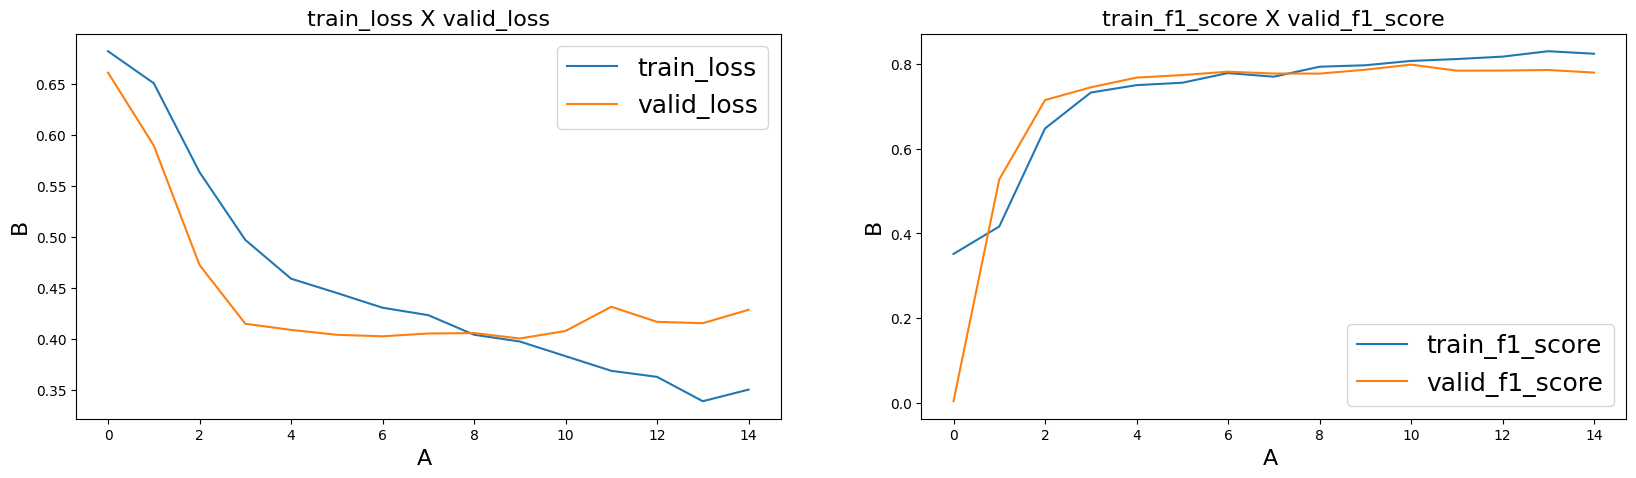

In [19]:
def plot_learning_curves(history, arr):
    fig, ax = plt.subplots(1, 2, figsize=(20, 5))
    for idx in range(2):
        ax[idx].plot(history[arr[idx][0]])
        ax[idx].plot(history[arr[idx][1]])
        ax[idx].legend([arr[idx][0], arr[idx][1]],fontsize=18)
        ax[idx].set_xlabel('A ',fontsize=16)
        ax[idx].set_ylabel('B',fontsize=16)
        ax[idx].set_title(arr[idx][0] + ' X ' + arr[idx][1],fontsize=16)
        
plot_learning_curves(history, [['train_loss', 'valid_loss'],['train_f1_score', 'valid_f1_score']])

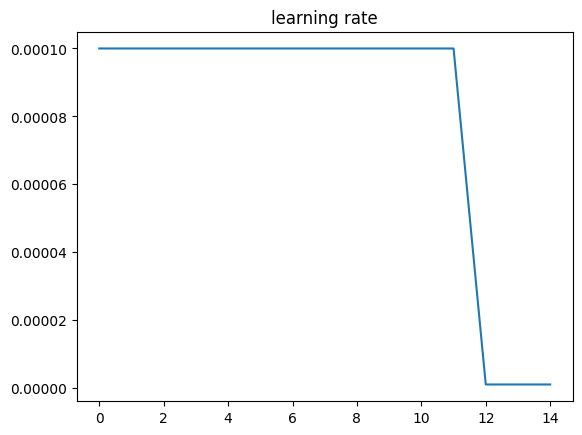

In [20]:
plt.plot(history['learning_rate'])
plt.title("learning rate");

In [21]:
labels, preds = model_predict(valid_dataloader)

print("For pytorh")
print(classification_report(labels, preds))

  0%|          | 0/36 [00:00<?, ?it/s]

For pytorh
              precision    recall  f1-score   support

           0       0.85      0.84      0.84       651
           1       0.79      0.80      0.79       490

    accuracy                           0.82      1141
   macro avg       0.82      0.82      0.82      1141
weighted avg       0.82      0.82      0.82      1141



# SUBMIT

In [22]:
predictions = []

model.eval()
with torch.no_grad():
    for idx, texts in enumerate(tqdm(test_dataloader)):
        texts = texts.to(CFG.DEVICE)

        predicted_probs = model(texts).flatten()

        preds = predicted_probs.cpu().detach().numpy().round()

        predictions.append(preds.astype('int')) 
        
preds = np.concatenate(predictions)

  0%|          | 0/102 [00:00<?, ?it/s]

In [23]:
sample_sub['target'] = preds
sample_sub.head()

,id,target
0,0,1
1,2,1
2,3,1
3,9,1
4,11,1


In [24]:
sample_sub.to_csv("pytorch_model_submission.csv", index=False)